In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from tqdm import tqdm

In [2]:
path_to_data = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

In [4]:
image_filenames = os.listdir(path_to_data)
original_image = []
cnt = 0
for filename in tqdm(image_filenames):
    full_filename = os.path.join(path_to_data, filename)
    imported_image = Image.open(full_filename)
    original_image.append(imported_image)
    cnt += 1
    if cnt >= 12000:
        break

  6%|▌         | 11999/202599 [00:56<15:01, 211.40it/s]


In [5]:
input_size = 224
crop_size = 112

In [164]:
transform_train = [
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]
transform_test = [
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

In [165]:
class Image_Dataset(Dataset):
    def __init__(self, transform):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform

    def __len__(self):
        return len(original_image)

    def __getitem__(self, idx):
        imported_image = original_image[idx]
        for t in self.transform:
            imported_image = t(imported_image)
        processed_image = imported_image.clone()
        x1 = random.randint(0, input_size-crop_size-1)
        y1 = random.randint(0, input_size-crop_size-1)
        x2 = x1 + crop_size
        y2 = y1 + crop_size
        cropped = imported_image[:, x1:x2, y1:y2].clone()
        imported_image[:, x1:x2, y1:y2] = 0
        return imported_image.clone(), cropped, processed_image

In [166]:
test_img = Image.open("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg")
for t in transform_train:
    test_img = t(test_img)

In [167]:
test_img.shape

torch.Size([3, 224, 224])

In [168]:
random.randint(0, input_size-crop_size-1)

106

In [169]:
batch_size = 128

In [170]:
train_dataset = Image_Dataset(transform_train)

In [171]:
test_dataset = Image_Dataset(transform_test)

In [172]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

In [175]:
for i, (masked, target, original) in enumerate(tqdm(train_dataloader)):
    pass
#         total_loss = 0
#         masked, target = masked.to(device), target.to(device)

100%|██████████| 94/94 [00:18<00:00,  5.02it/s]


Note that cannot use ReLU. If not the prediction will be all zero because backprop the ReLU backwards gradient is mostly zero. Use leaklyReLU and set a relatively high backward slope (like 0.2)
Use Tanh() for last layer since we are trying to predict pixel values between -1 and 1 (since we used Normalize([0.5]) in our transformations)

In [180]:
class CACNN(nn.Module):
    def __init__(self, channels):
        super().__init__()
        def downsample(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=(4,4), stride=2, padding=1)]
#             nn.init.xavier_uniform_(layers[0].weight)
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        def upsample(in_channels, out_channels, normalize=True):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(4,4), stride=2, padding=1)]
#             nn.init.xavier_uniform_(layers[0].weight)
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
#             *downsample(256, 512),
            nn.Conv2d(256, 256, 1),
#             *upsample(4000, 512),
#             *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            *upsample(64, 64),
#             nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
#             nn.Tanh(),
#             nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
#             nn.Tanh(),
            nn.Conv2d(64, channels, kernel_size=(3, 3), stride=1, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.model(x)

In [181]:
device = "cuda"
CACNN_net = CACNN(3).to(device)

In [182]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(CACNN_net)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  model.0.weight |    3072    |
|   model.0.bias  |     64     |
|  model.2.weight |   65536    |
|   model.2.bias  |     64     |
|  model.3.weight |     64     |
|   model.3.bias  |     64     |
|  model.5.weight |   131072   |
|   model.5.bias  |    128     |
|  model.6.weight |    128     |
|   model.6.bias  |    128     |
|  model.8.weight |   524288   |
|   model.8.bias  |    256     |
|  model.9.weight |    256     |
|   model.9.bias  |    256     |
| model.11.weight |   65536    |
|  model.11.bias  |    256     |
| model.12.weight |   524288   |
|  model.12.bias  |    128     |
| model.13.weight |    128     |
|  model.13.bias  |    128     |
| model.15.weight |   131072   |
|  model.15.bias  |     64     |
| model.16.weight |     64     |
|  model.16.bias  |     64     |
| model.18.weight |   65536    |
|  model.18.bias  |     64     |
| model.19.weight |     64     |
|  model.1

1514563

In [183]:
CACNN_net(test_img.unsqueeze(0).to(device)).shape

torch.Size([1, 3, 112, 112])

In [192]:
import torch.optim

optimizer = torch.optim.Adam(CACNN_net.parameters(), lr=0.001)
criteria = nn.MSELoss().to(device)

In [193]:
for _ in range(5):
    total_loss = 0
    for i, (masked, target, original) in enumerate(train_dataloader):
        masked, target, original = masked.to(device), target.to(device), original.to(device)
        
        optimizer.zero_grad()
        predicted = CACNN_net(masked)
#         predicted = CACNN_net(original)
        loss = criteria(target, predicted)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i%20 == 19:
            print("Batch {}\n Average loss: {}".format(i+1, total_loss/20))
            total_loss = 0

Batch 20
 Average loss: 0.29527873247861863
Batch 40
 Average loss: 0.295382034778595
Batch 60
 Average loss: 0.29382190108299255
Batch 80
 Average loss: 0.2988583087921143
Batch 20
 Average loss: 0.2929225876927376
Batch 40
 Average loss: 0.2927061513066292
Batch 60
 Average loss: 0.29531373977661135
Batch 80
 Average loss: 0.2963372677564621
Batch 20
 Average loss: 0.29644021242856977
Batch 40
 Average loss: 0.2942062050104141
Batch 60
 Average loss: 0.2922427862882614
Batch 80
 Average loss: 0.2931788608431816
Batch 20
 Average loss: 0.2953008383512497
Batch 40
 Average loss: 0.2930851861834526
Batch 60
 Average loss: 0.2937998592853546
Batch 80
 Average loss: 0.2911956116557121
Batch 20
 Average loss: 0.2917598471045494
Batch 40
 Average loss: 0.2906214535236359
Batch 60
 Average loss: 0.29397452622652054
Batch 80
 Average loss: 0.2953769564628601


In [189]:
print(CACNN_net.model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): LeakyReLU(negative_slope=0.2)
  (15): Co

In [190]:
from matplotlib.pyplot import plot

tensor(0.9730)


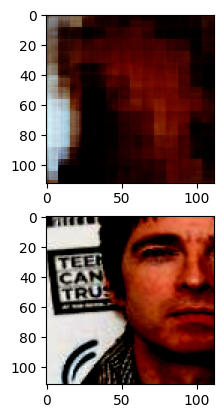

In [194]:
with torch.no_grad():
    for i, (masked, target, original) in enumerate(test_dataloader):
        masked, target, original = masked.to(device), target.to(device), original.to(device)
        predicted = CACNN_net(masked)
        _, axarr = plt.subplots(2)
        print(predicted[0].cpu().max())
        axarr[0].imshow(predicted[0].cpu().permute(1,2,0))
        axarr[1].imshow(target[0].cpu().permute(1,2,0))
        break